Basic Imports


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline

Camera Calibration




Draw Corners on Calibration images

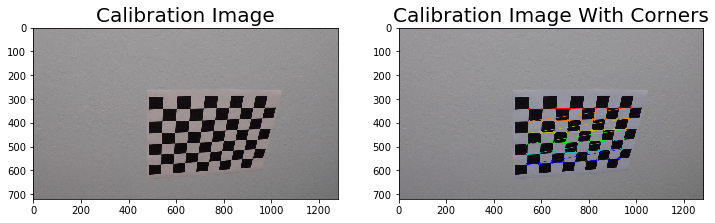

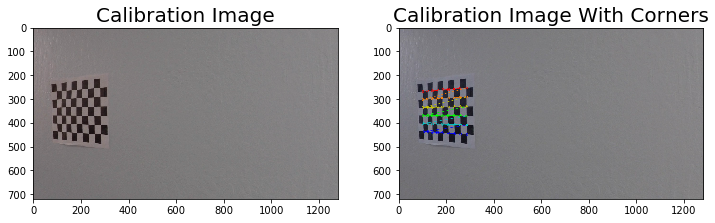

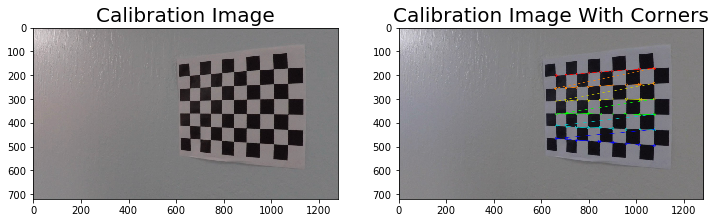

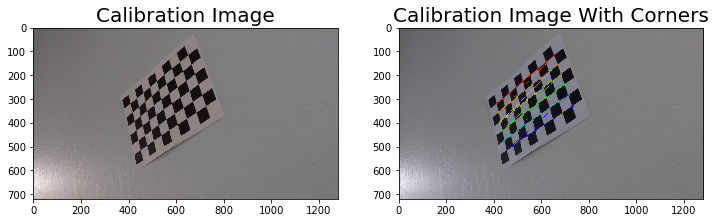

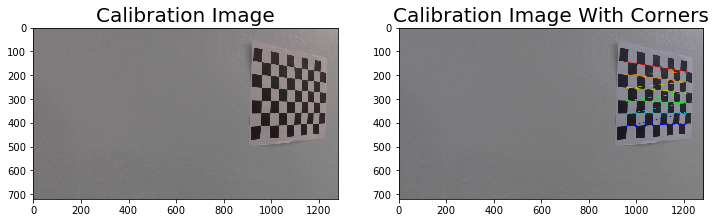

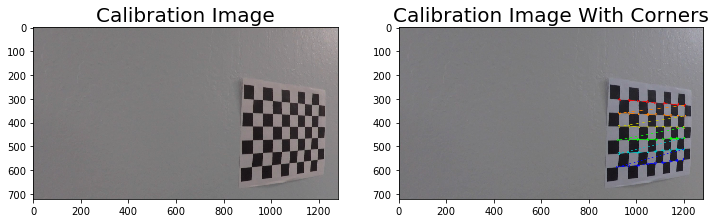

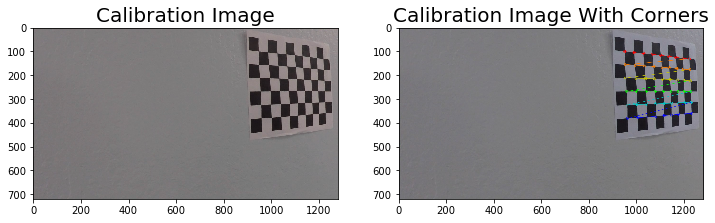

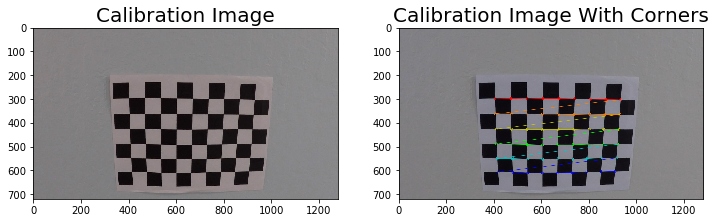

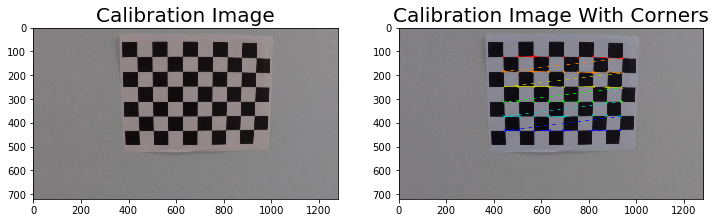

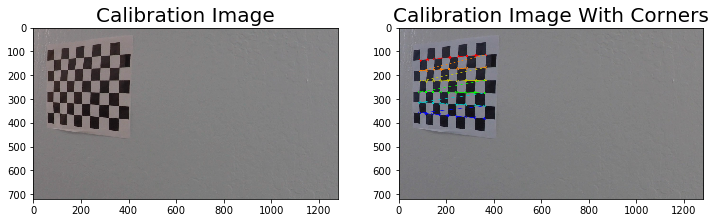

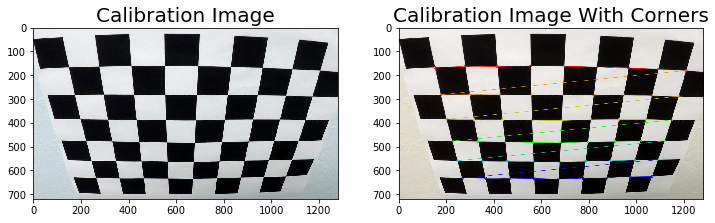

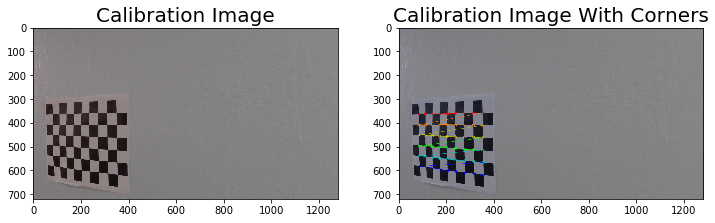

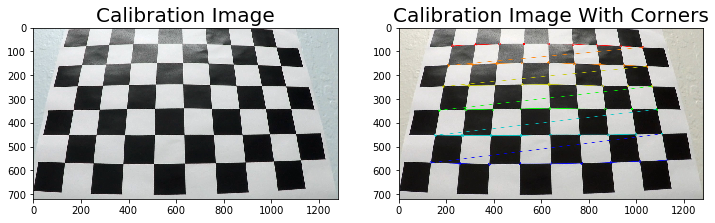

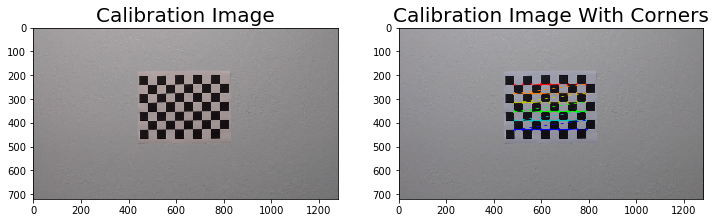

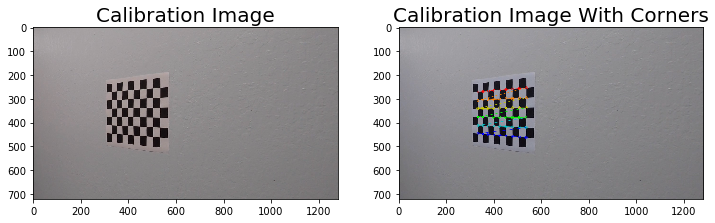

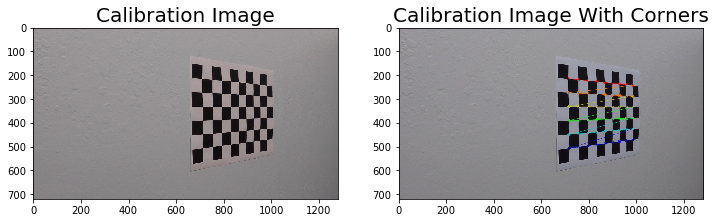

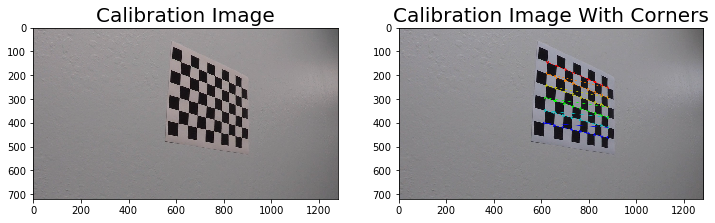

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
        ax1.imshow(cv2.cvtColor(mpimg.imread(fname), cv2.COLOR_BGR2RGB))
        ax1.set_title('Calibration Image', fontsize=20)
        ax2.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax2.set_title('Calibration Image With Corners', fontsize=20)

Calibrate camera then use mtx and dist coefficients  to undistort image

In [3]:
# Function that Corrects distortion
def undistort(image):
    img_size = (image.shape[1], image.shape[0])
    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    corrected = cv2.undistort(image, mtx, dist, None, mtx)
    return corrected

Undistort test images and display results

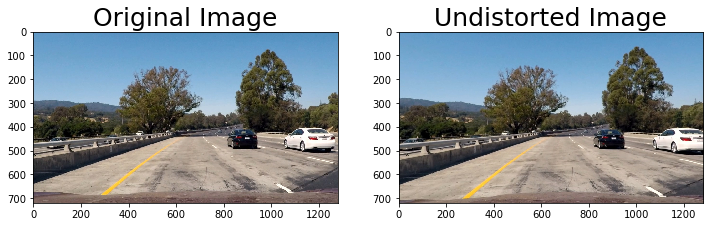

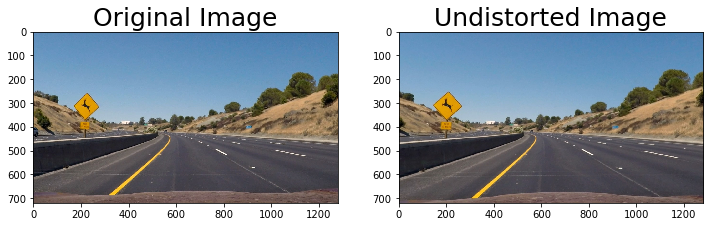

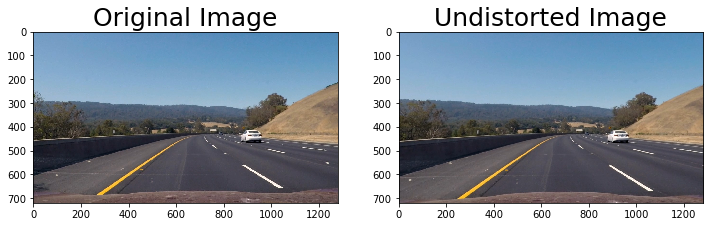

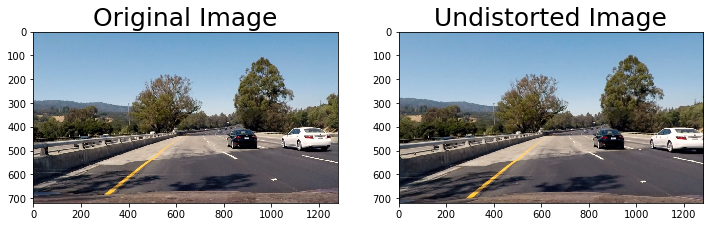

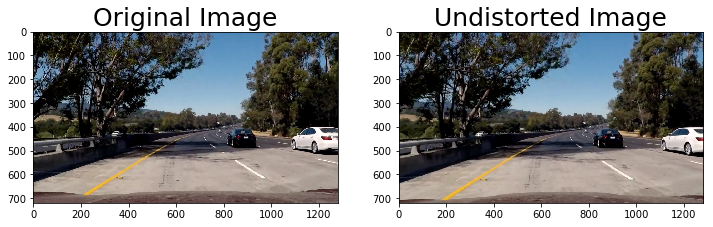

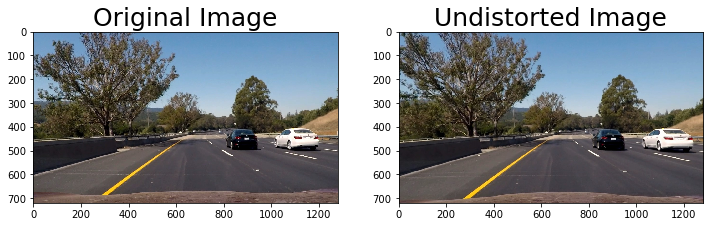

In [4]:
images = glob.glob('test_images/test*.jpg')
for img in images:
    image = cv2.imread(img)
    corrected = undistort(image)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
    ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax1.set_title('Original Image', fontsize=25)
    ax2.imshow(cv2.cvtColor(corrected, cv2.COLOR_BGR2RGB))
    ax2.set_title('Undistorted Image', fontsize=25)

Warp image and perform a bird eye view transform


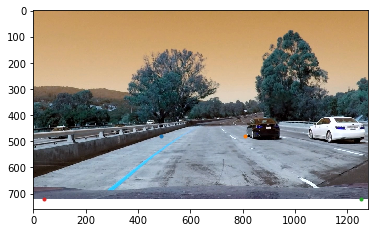

In [5]:
# Eyeballing the image and experimeting with src -> dst points to be used for the perspective transform
image = cv2.imread('test_images/test1.jpg')

plt.imshow(image)
plt.plot(488, 480,'.')
plt.plot(808, 480,'.')
plt.plot(1252, 722,'.')
plt.plot(42, 722,'.')


In [6]:
#########################
# SOURCE AND DESTINATION POINTS #
     
# Source points
src = np.float32([[488, 480],[808, 480],
                    [1252, 722],[42, 722]])
dst = np.float32([[0, 0], [1280, 0], 
                     [1252, 722],[42, 722]])
########################

 ##############################
# DEFINE PERSPECTIVE TRANSFORM #
 #############################

M = cv2.getPerspectiveTransform(src,dst)
Minv = cv2.getPerspectiveTransform(dst, src)

Let's see how the transform works on the test images


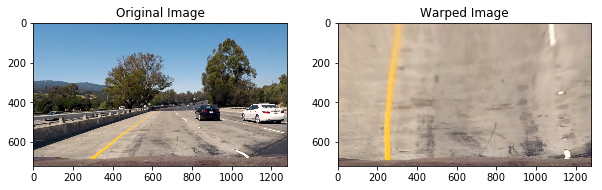

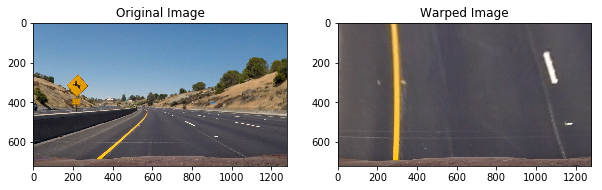

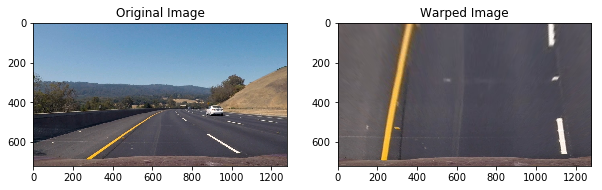

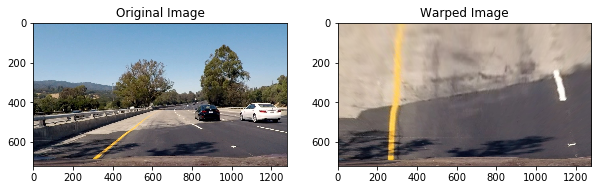

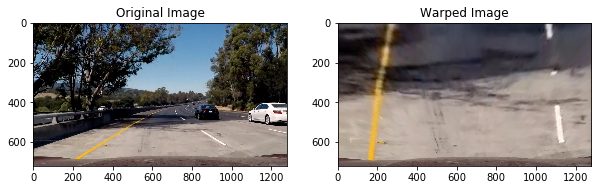

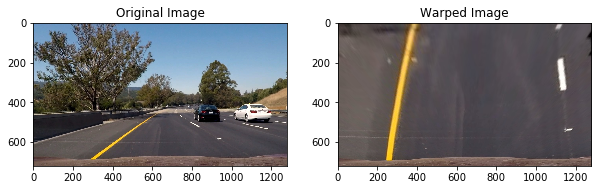

In [7]:
for img in images:
    image = cv2.imread(img)
    img_size = (image.shape[1], image.shape[0])
    plt.figure(figsize=(10,40))
    plt.subplot(1,2,1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), cmap='gray')
    plt.title('Original Image')
    plt.subplot(1,2,2)
    warped_image = cv2.warpPerspective(image, M, img_size)
    plt.imshow(cv2.cvtColor(warped_image, cv2.COLOR_BGR2RGB), cmap='gray')
    plt.title('Warped Image')

Let's explore gradient thresholding using sobel operators

In [8]:
# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
# Note: calling your function with orient='x', thresh_min=5, thresh_max=100
# should produce output like the example image shown above this quiz.
def abs_sobel_thresh(img, orient='x', abs_thresh=(5, 100)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= abs_thresh[0]) & (scaled_sobel <= abs_thresh[1])] = 1
    # Return the result
    return binary_output

# Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(img, sobel_kernel=3, m_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= m_thresh[0]) & (gradmag <= m_thresh[1])] = 1
    # Return the binary image
    return binary_output

# Define a function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def dir_threshold(img, sobel_kernel=3, d_thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= d_thresh[0]) & (absgraddir <= d_thresh[1])] = 1
    return binary_output
    
# Apply each of the thresholding functions
def combined_gradient_threshold_all(image, sobel_kernel=3, x_thresh=(20, 100), y_thresh=(20, 100), m_thresh=(30, 100), d_thresh=(0.7, 1.3)):
    gradx = abs_sobel_thresh(image, 'x', x_thresh)
    grady = abs_sobel_thresh(image, 'y', y_thresh)
    mag_binary = mag_thresh(image, sobel_kernel, m_thresh)
    dir_binary = dir_threshold(image, sobel_kernel, d_thresh)
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    return combined

# Apply each of the thresholding functions
def combined_gradient_threshold(image, sobel_kernel=3, m_thresh=(30, 100), d_thresh=(0.7, 1.3)):
    mag_binary = mag_thresh(image, sobel_kernel, m_thresh)
    dir_binary = dir_threshold(image, sobel_kernel, d_thresh)
    combined = np.zeros_like(dir_binary)
    combined[((mag_binary == 1) & (dir_binary == 1))] = 1
    return combined



def warp_gradient_thershold(image, ksize=3, x_thresh=(20, 100), y_thresh=(20, 100), m_thresh=(30, 100), d_thresh=(0.7, 1.3)):
    img_size = (image.shape[1], image.shape[0])
    warped_image = cv2.warpPerspective(image, M, img_size)
    thersholded_image = combined_gradient_threshold(warped_image, ksize, m_thresh, d_thresh)
    return thersholded_image


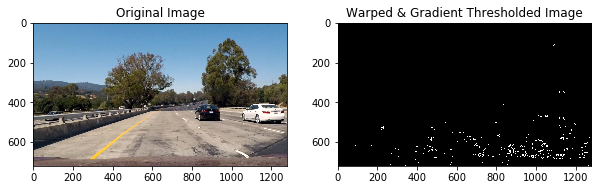

In [9]:
sobel_kernel=13 
m_thresh=(30, 100)
d_thresh=(0.8, 1.2)



image = cv2.imread('test_images/test1.jpg')
plt.figure(figsize=(10,40))
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), cmap='gray')
plt.title('Original Image')
plt.subplot(1,2,2)

grad_thresh_image = warp_gradient_thershold(image, sobel_kernel, m_thresh, d_thresh)

plt.imshow(grad_thresh_image, cmap='gray')
plt.title('Warped & Gradient Thresholded Image')



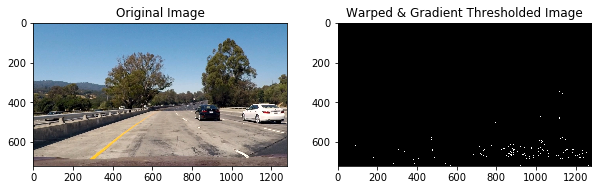

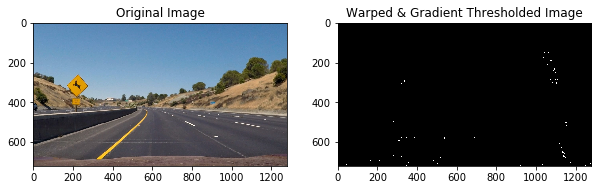

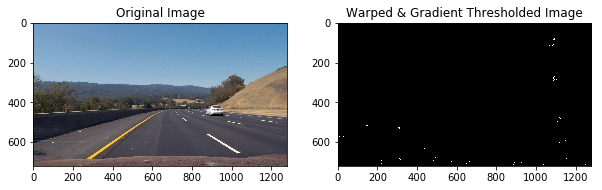

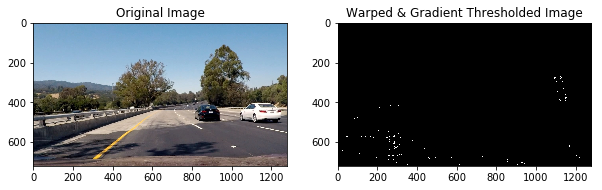

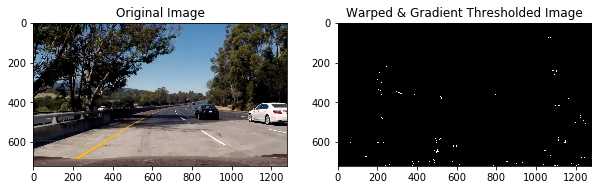

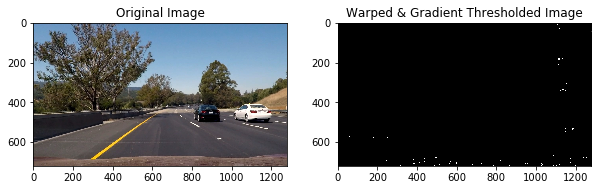

In [10]:
# Setting kernel size and various threshold values
ksize=3 
m_thresh=(10, 130)
d_thresh=(0.4, 1.6)
    
for img in images:
    image = cv2.imread(img)
    plt.figure(figsize=(10,40))
    plt.subplot(1,2,1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), cmap='gray')
    plt.title('Original Image')
    plt.subplot(1,2,2)
    grad_thresh_image = warp_gradient_thershold(image, ksize, m_thresh, d_thresh)
    plt.imshow(grad_thresh_image, cmap='gray')
    plt.title('Warped & Gradient Thresholded Image')

Let's explore color thersholding and specifically the HLS and LUV spaces

In [11]:
def threshold_image(img, s_thresh=(0, 255), l_channel=(0, 255)):
    s_channel = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)[:,:,2]           
    l_channel = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)[:,:,0]
    
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    
    combined_binary = np.zeros_like(s_binary)
#    combined_binary[(s_binary == 1)] = 1
    combined_binary[(s_binary == 1) | (l_binary == 1)] = 1
    return combined_binary

#    
def color_thershold(image , s_thresh=(0, 255), l_channel=(0, 255)):
    img_size = (image.shape[1], image.shape[0])
    thersholded_image = threshold_image(image, s_thresh, l_channel)
    return thersholded_image


#def color_thershold(image , s_thresh=(0, 255), l_thresh=(0, 255)):
    #img_size = (image.shape[1], image.shape[0])
    #warped_image = cv2.warpPerspective(image, M, img_size)
    #thersholded_image = threshold_image(warped_image, s_thresh, l_thresh)
    #return thersholded_image
    

Let's see what the following threshold values will give us

s_thresh=(180, 255)
l_thresh=(155, 255)

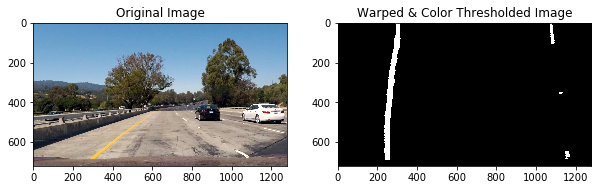

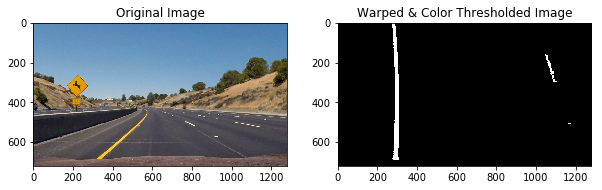

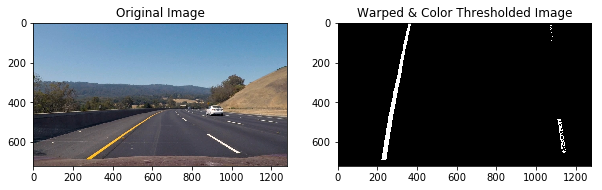

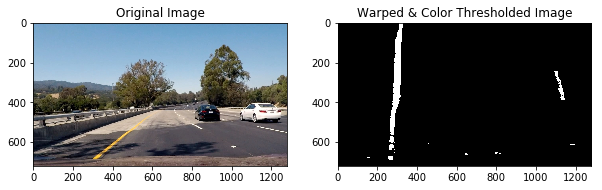

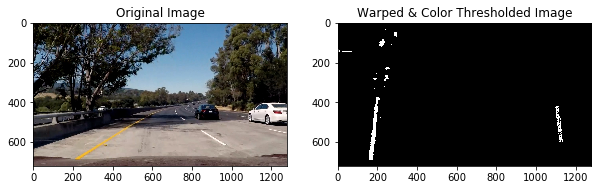

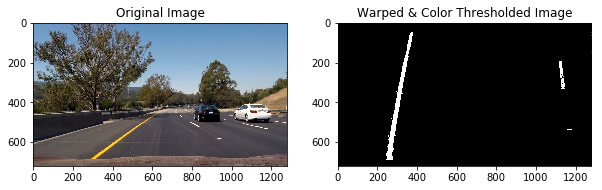

In [12]:
s_thresh=(180, 255) 
l_thresh=(255, 255)

for img in images:
    image = cv2.imread(img)
    plt.figure(figsize=(10,40))
    plt.subplot(1,2,1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), cmap='gray')
    plt.title('Original Image')
    plt.subplot(1,2,2)
    warped_image = cv2.warpPerspective(image, M, img_size)
    color_thersh_image = color_thershold(warped_image, s_thresh)
    plt.imshow(color_thersh_image, cmap='gray')
    plt.title('Warped & Color Thresholded Image')

Color Thresholding seems to be working pretty well so we'll use it instead of gradient (gradient could work too I just haven't been successful yet to find the right thresholds)

In [13]:
# adjust thersholds here if needed
s_thresh=(180, 255)
l_thresh=(255, 255)


left_fit_mem = []
right_fit_mem = []

def fit_lines(binary_warped):

    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # Finding peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Number of sliding windows
    nwindows = 9
    
    # Height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    # Identifing the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Margin in which to search
    margin = 100
    
    # Minimum number of pixels found to recenter window
    minpix = 50
    
    # Empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Steping through windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Drawing the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identifing the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        # Appending these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # Recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    # Concatenating the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extracting left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    
    if ( (leftx.size == 0) | (righty.size == 0)) :
        return left_fit_mem, right_fit_mem, out_img, curvl, curvr
    
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    curvl,curvr = curvature(binary_warped, leftx, rightx, left_lane_inds, right_lane_inds)
    
    if ( (left_fit.size == 0) | (right_fit.size == 0)) :
        return left_fit_mem, right_fit_mem, out_img, curvl, curvr
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    return left_fit, right_fit, out_img, curvl, curvr


def curvature(binary_warped, l_fit, r_fit, l_lane_inds, r_lane_inds):
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    height = binary_warped.shape[0]
    ploty = np.linspace(0, height-1, height)
    y_eval = np.max(ploty)
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Again, extract left and right line pixel positions
    leftx = nonzerox[l_lane_inds]
    lefty = nonzeroy[l_lane_inds] 
    rightx = nonzerox[r_lane_inds]
    righty = nonzeroy[r_lane_inds]

    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    return left_curverad,right_curverad


def plot_line_fit(image):
#    image = cv2.imread('test_images/test1.jpg')
    undistorted = undistort(image)
    b_thresholded = color_thershold(undistorted, s_thresh, l_thresh)
    #          1280,720
    img_size = (b_thresholded.shape[1], b_thresholded.shape[0])
    w, h = img_size
    binary_warped = cv2.warpPerspective(b_thresholded,M, img_size)
    
    left_fit, right_fit, out_img, curvl , curvr = fit_lines(binary_warped)

    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    

    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    
    plt.figure(figsize=(10,40))
    plt.subplot(1,2,1)
    plt.imshow(binary_warped, cmap='gray')
    plt.title('Binary Warped')
    
    plt.subplot(1,2,2)
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    plt.title('Lane Detected. Curvature, left: ' + str(int(curvl)) + ', right: ' + str(int(curvr)))
    return
 

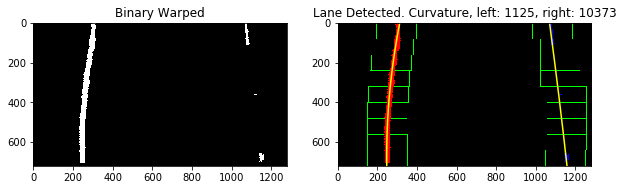

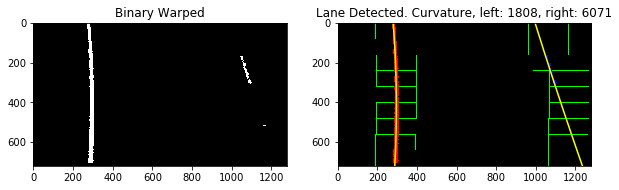

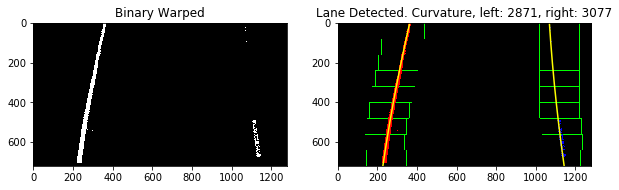

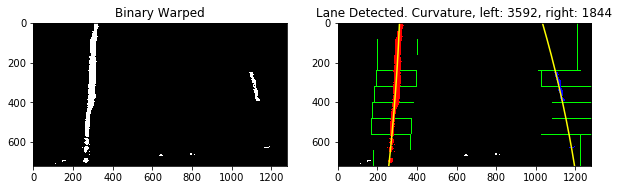

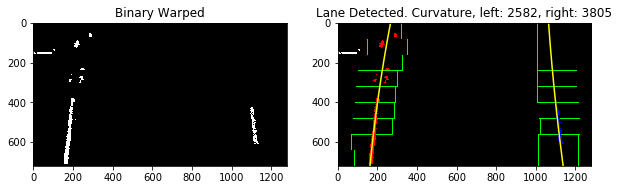

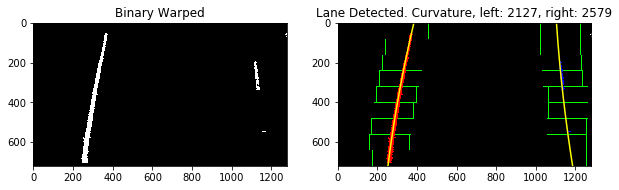

In [14]:
#image = cv2.imread('test_images/test2.jpg')
#plot_line_fit(image)


for img in images:
    image = cv2.imread(img)
    plot_line_fit(image)

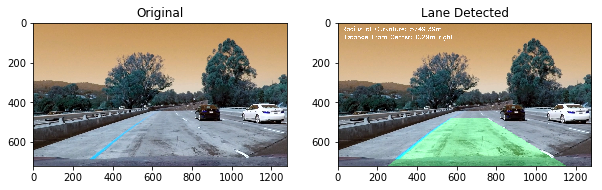

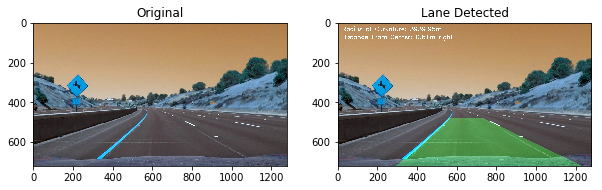

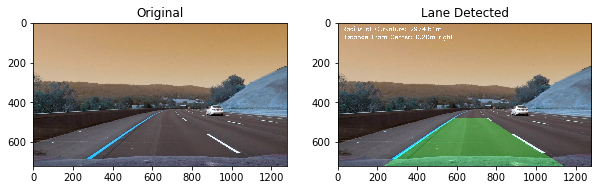

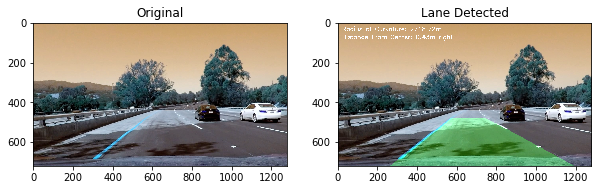

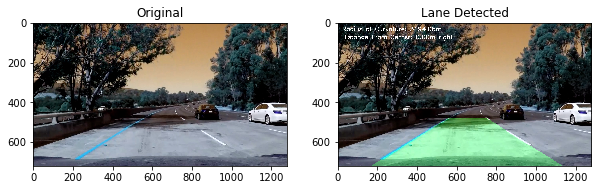

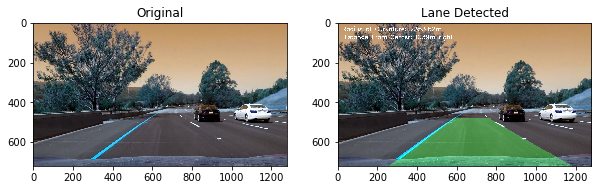

In [15]:
class Line():
    def __init__(self):
        self.fit = None  

## Input Binary warped an leftfit right fit
def plot_back(left_fit, right_fit, image, curvature):
    undistorted_img = undistort(image)
    b_thresholded = color_thershold(undistorted_img, s_thresh, l_thresh)
    img_size = (b_thresholded.shape[1], b_thresholded.shape[0])
    width, height = img_size 
    binary_warped = cv2.warpPerspective(b_thresholded, M, (width, height))
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    
    cv2.putText(result,'Radius of Curvature: %.2fm' % curvature, (20,40), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)
    
    x_left_pix = left_fit[0]*(y_eval**2) + left_fit[1]*y_eval + left_fit[2]
    x_right_pix = right_fit[0]*(y_eval**2) + right_fit[1]*y_eval + right_fit[2]
    position_from_center = ((x_left_pix + x_right_pix)/2 - midx) * xm_per_pix
    if position_from_center < 0:
        text = 'left'
    else:
        text = 'right'
    cv2.putText(result,'Distance From Center: %.2fm %s' % (np.absolute(position_from_center), text),(20,80), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)

    return result


ym_per_pix = 3.0/72.0 # meters per pixel in y dimension
xm_per_pix = 3.7/660.0 # meters per pixel in x dimension
y_eval = 700
midx = 650


Left = Line()
Right = Line()

def pipeline(image):
    undistorted_img = undistort(image)
    color_thresholded = color_thershold(undistorted_img, s_thresh, l_thresh)
    img_size = (color_thresholded.shape[1], color_thresholded.shape[0])
    w, h = img_size
    
    binary_warped = cv2.warpPerspective(color_thresholded, M, img_size)
    left_fit, right_fit, out_img, curvl , curvr = fit_lines(binary_warped)
    
    curvature = (curvl + curvr)/2 
    
    if ((len(right_fit)==0) | (len(left_fit)==0)):
        left_fit, right_fit = Left.fit, Right.fit
    else:
        Left.fit, Right.fit = left_fit, right_fit
        
        
    left_fitx_720 = left_fit[0]*w**2 + left_fit[1]*w + left_fit[2]
    right_fitx_720 = right_fit[0]*w**2 + right_fit[1]*w + right_fit[2]
    
    delta_0 = right_fit[2] - left_fit[2]
    
    delta_720 = right_fitx_720 - left_fitx_720
    
    delta_avg = (delta_0 + delta_720)/2
    
    if ((delta_0 <= 700) | (delta_0 >= 850) ):
        # Bad Fit user previous 
        left_fit, right_fit = Left.fit, Right.fit
    else:
        Left.fit, Right.fit = left_fit, right_fit
    
    result = plot_back(left_fit, right_fit, image, curvature)
    return result



    
for img in images:
    image = cv2.imread(img)
    result = pipeline(image)
    
    plt.figure(figsize=(10,40))
    plt.subplot(1,2,1)
    plt.imshow(image, cmap='gray')
    plt.title('Original')
    
    plt.subplot(1,2,2)
    plt.imshow(result)
    plt.title('Lane Detected')

Creating video

In [16]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Left = Line()
Right = Line()
white_output = 'project_video_result.mp4'
clip1 = VideoFileClip("./project_video.mp4").subclip(46,49)
white_clip = clip1.fl_image(pipeline)
%time white_clip.write_videofile(white_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))



[MoviePy] >>>> Building video project_video_result.mp4
[MoviePy] Writing video project_video_result.mp4


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 75/76 [01:11<00:00,  1.05it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_result.mp4 

Wall time: 1min 12s
